# Introduzione

L'obiettivo è quello di analizzare il dataset sui funghi, e testare diversi classificatori per trovare il migliore nel classificare nuovi funghi come commestibili o velenosi. Il documento è composto come segue:

- Data Exploration
    - Analisi classi dataset
    - Feature Selection
    - Rimozione righe malformate
- Test Classificatori
    - Naive Bayes
    - Random Forest
    - ...
    - ...

Import delle librerie necessarie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import statsmodels.api as sm
import warnings
#altri import futuri

Caricamento del dataset

In [8]:
dataset = pd.read_csv("dataset/dataset.csv", sep=",")
dataset_bak = dataset
dataset.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


# Data Exploration

## Class Balancing

Siamo interessati a classificare i pazienti ricoverati come 'in pericolo di vita' oppure 'in salute'. Per questo motivo identifichiamo le due classi di interesse a partire dalla colonna ```hospital_death``` del dataset. Vogliamo vedere quanto sono bilanciate le classi del dataset.

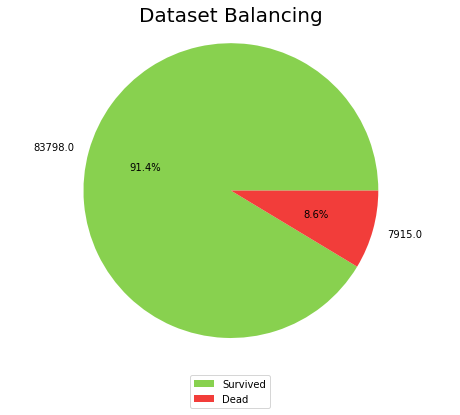

In [3]:
classes = [{"Survived": (dataset["hospital_death"] == 0).sum(), "Dead": (dataset["hospital_death"] == 1).sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Survived"])
total_p = float(total["Dead"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Survived','Dead'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(mushrooms,labels=mushrooms,autopct='%1.1f%%',colors = ['#88d14f', '#f23d3a'])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(mushrooms_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Come possiamo vedere il dataset è altamente sbilanciato. Infatti abbiamo il 91.4% di righe che riportano dati per un paziente sopravvissuto, mentre solo l'8.6% di dati per un paziente deceduto. Ciò implica dire che qualsiasi modello allenato su un training set ricavato da tale dataset tenderà maggiormente a classificare un'istanza come 'survived', aspettandoci quindi molti falsi negativi. (Positivo = death, Negativo = survived)

## Visualizzazione features

Andiamo a visualizzare la distribuzione delle features all'interno del dataset, riportando in un barplot le variabili categoriche e in un histplot le variabili numeriche.

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

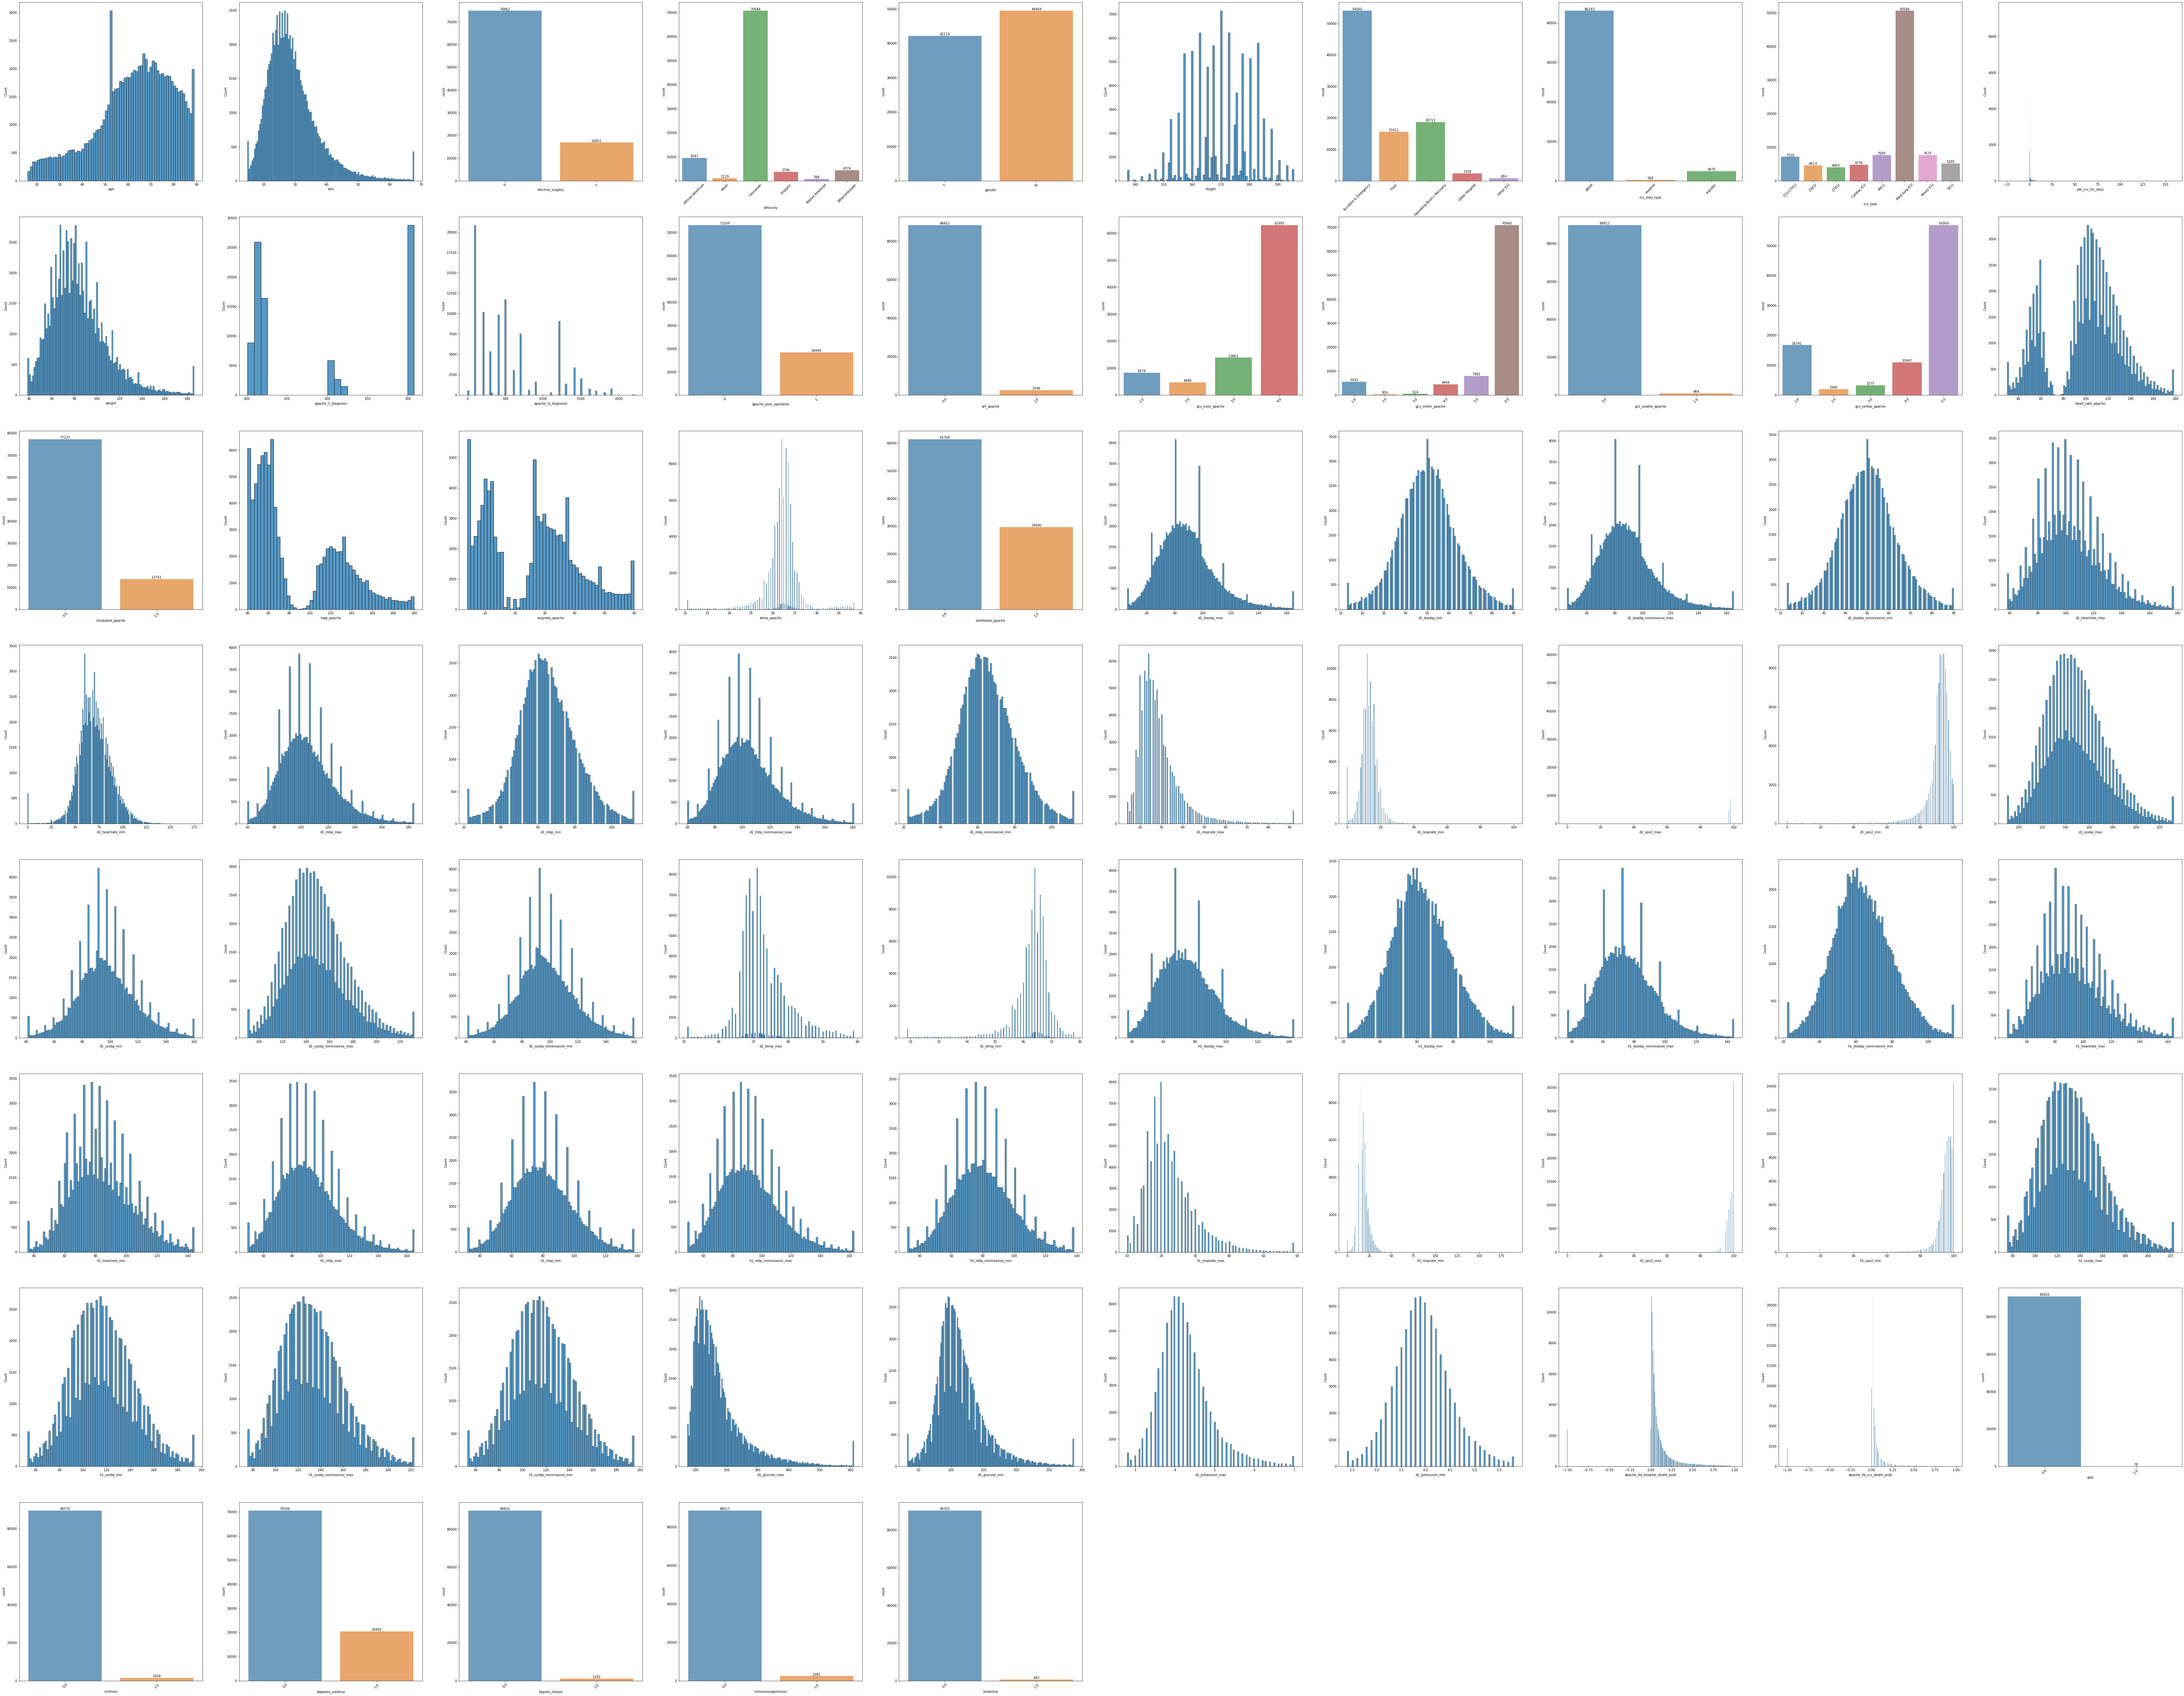

In [20]:
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
ignore = ['encounter_id','patient_id','Unnamed: 83','hospital_id','icu_id','hospital_death']
categ = []
numer = []

for col in dataset.drop(columns=ignore): 
    dt = dataset[col].dtype
    if dt == "object":
        categ.append(col)
    elif dt == "float64":
        if dataset[col].dropna().nunique()<10:
            dataset[col] = dataset[col].astype('object')
            categ.append(col)
        else:
            numer.append(col)
    elif dt == "int64":
        dataset[col] = dataset[col].astype('object')
        categ.append(col)

fig = plt.figure(figsize=(120,120))
j=1
a=0
b=0
for i in range(0, len(dataset.columns)-len(ignore)):
    col = dataset.columns[i]

    if col in categ:
        fig.add_subplot(10,10,j)
        ax = sns.countplot(x=categ[a], data=dataset, alpha=.7, order=sorted(dataset[col].dropna().unique().tolist(),key=str))
        ax.bar_label(ax.containers[0])
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
        j += 1
        a += 1

    elif col in numer:
        fig.add_subplot(10,10,j)
        sns.histplot(dataset[numer[b]].dropna(), kde_kws={"lw": 2, "color":colors[8]})
        j += 1
        b += 1

## Visualizzazione campi non nulli

Visualizzazione campi non nulli per ogni colonna/feature del dataset. Questo ci serve per vedere eventuali colonne che possono poi essere rimosse

In [ ]:
def plot_nas(datasetX, use_threshold, threshold=None):
    to_delete = []
    if datasetX.isnull().sum().sum() != 0:
        na_datasetX = (datasetX.isnull().sum() / len(datasetX)) * 100
        na_datasetX = na_datasetX.drop(na_datasetX[na_datasetX == 0].index).sort_values(ascending=False)
        to_delete = na_datasetX[na_datasetX > threshold]

        missing_data = pd.DataFrame({'Null Ratio %' :na_datasetX})
        missing_data.plot(kind = "barh")
        plt.rcParams['figure.figsize'] = (20,20)

        if use_threshold:
            plt.axvline(x=threshold, color='red')
            #plt.text(threshold-2,-1.5,'thr = 50', color = 'red')
        plt.show()
        
    else:
        print('No NAs found')
        return None
    
    if use_threshold:
        print(to_delete.index.tolist())
    return to_delete.index.tolist()
        

p = plot_nas(dataset,use_threshold=False)

Analizzando la distribuzione delle varie features possiamo vedere come il dataset sia di buona qualità, avendo pochi campi non nulli. Tuttavia la feature ```Unnamed: 83``` presenta soltanto campi nulli, e quindi verrà eliminata in una successiva fase di pulizia del dataset.

Le restanti features presentano valori `NaN` per una percentuale sempre inferiore al 20%, motivo per cui possiamo procedere con una imputazione di tali dati, senza introdurre un rumore eccessivo nel dataset. 

## Conversione Features e Mapping

Conversione delle features categoriche in nominali, si modifica prima il tipo di dato dei valori delle features da ```object``` in ```category``` per poi procedere con l'effettiva trasformazione dei valori categorici.

Si trasformano i valori categorici in numerici (int64) e si salva il dizionario che mantiene il mapping per un eventuale utilizzo futuro.

In [ ]:
mapped_dataset = dataset.copy()
encoder = LabelEncoder()
mapping = []

for i in range(len(mapped_dataset.columns)):
    
    if (mapped_dataset[mapped_dataset.columns[i]].dtype == "object"):
            mapped_dataset[mapped_dataset.columns[i]] = encoder.fit_transform(mapped_dataset[mapped_dataset.columns[i]])
            mapping_dict = {index : label for index , label in enumerate(encoder.classes_)}
            mapping.append(mapping_dict)

mapped_dataset = mapped_dataset.where(~dataset.isna(), dataset)


Visualizziamo il mapping effettuato delle variabili categoriche.

- _NOTA_: I valori `NaN` risultano mappati nel dizionario, ma tramite la clausola ```where(~dataset.isna(), dataset)``` ristabiliamo i valori NaN originali per la successiva fase di imputazione dei dati.

In [ ]:
print(mapping)

Completiamo trasformando il tipo di dato associato alle features categoriche da ```object``` in ```float64```, oggetto che accetta valori interi nulli.

In [ ]:
for el in mapped_dataset.columns:
    if (mapped_dataset[el].dtype == "object"):
        mapped_dataset[el] = np.floor(pd.to_numeric(mapped_dataset[el], errors='coerce')).astype('float64')

Vediamo che abbiamo mappato le nostre variabili categoriche in variabili ordinali. I valori nulli sono stati mantenuti <NaN> per una successiva fase di imputazione. 

In [ ]:
mapped_dataset.info()

## Feature Correlation

Vediamo il grado di correlazione reciproco tra le varie feature, compresa la correlazione di ogni feature con il target. In generale vogliamo che una feature sia altamente correlata con il target (quindi che il suo valore sia importante per discriminare se il paziente sopravvive o muore). Una correlazione alta è sia positiva (aumento del valore di uno aumenta il valore dell'altro) che negativa (aumento del valore di uno diminuisce il valore dell'altro). Una correlazione vicina allo zero implica che le variabili sono indipendenti tra loro.

In [ ]:
plt.figure(figsize=(32,24), dpi=250)
correlation_matrix = mapped_dataset.drop(columns="Unnamed: 83").corr('spearman')
sns.heatmap(correlation_matrix, linewidths=0.05, cmap="PiYG", annot=True, annot_kws={"fontsize":4})
plt.yticks(rotation=0)
plt.show()

## Analisi Features

Analizziamo alcune tra le features più rilevanti rispetto al target

### Probabilità di morte in relazione all'età

In [ ]:
warnings.filterwarnings('ignore')

age_death_F=dataset[dataset['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
age_death_M=dataset[dataset['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()
fig,ax = plt.subplots(figsize = (12,8))
# name="Female patients"
sns.lineplot(x=age_death_F['age'], y=age_death_F['hospital_death'])
# name="Male patients"
sns.lineplot(x=age_death_M['age'], y=age_death_M['hospital_death'])
plt.title("Average hospital death probability of patients", fontsize = 20)

plt.legend(['Female',"Male"])
plt.xlabel("Patient Age")
plt.ylabel("Average Hospital Death")
fig.show()

warnings.filterwarnings('always')

### Probabilità di morte in relazione al BMI

In [ ]:
warnings.filterwarnings('ignore')

df=dataset[['hospital_death','bmi']]

df['bmi'] = df['bmi'].round(0)
bmi_death=df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()
fig,ax = plt.subplots(figsize = (12,8))
sns.lineplot(x=bmi_death['bmi'], y=bmi_death['hospital_death'])
plt.title("Impacts of BMI over patients", fontsize = 20)

plt.xlabel("BMI")
plt.ylabel("Average Hospital Death")
fig.show()

warnings.filterwarnings('always')

### Probabilità di morte in relazione a malattie critiche

In [18]:
(dataset['aids']==1).sum()

78

In [ ]:
warnings.filterwarnings('ignore')

df=dataset[['hospital_death','bmi']]

df['bmi'] = df['bmi'].round(0)
bmi_death=df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()
fig,ax = plt.subplots(figsize = (12,8))
sns.lineplot(x=bmi_death['bmi'], y=bmi_death['hospital_death'])
plt.title("Impacts of BMI over patients", fontsize = 20)

plt.xlabel("BMI")
plt.ylabel("Average Hospital Death")
fig.show()

warnings.filterwarnings('always')

# Training & Test Set Splitting

Andiamo a splittare il dataset in training e stesting set. Utilizziamo come percentuali 80/20

In [ ]:
targets = mapped_dataset['hospital_death']
trainX, testX, trainY, testY = train_test_split(mapped_dataset.drop(columns = 'hospital_death'), targets, test_size = 0.2, random_state=0)
print("TrainingSet:",trainX.shape)
print("TestingSet:",testX.shape)

trainX_og = trainX.copy()
testX_og = testX.copy()

# Results on Original Dataset

Andiamo a misurare le prestazioni di vari classificatori sul dataset originale, quindi senza ingegneria delle features e imputazione dei valori mancanti. 
- I classificatori considerati non gestiscono in modo automatico i valori ```NaN```
- Per eseguire la classificazione è comunque necessario mappare i valori ```NaN``` su un qualche valore numerico
- Si utilizza per questa fase di benchmark l'operatore ```fillna(-1)``` sostituendo quindi ```NaN``` con ```-1```

In [ ]:
def run_classifications(tr_x,train_Y,te_x,test_Y,fill,model=None,model_name=None):
    train_X = tr_x.copy()
    test_X = te_x.copy()

    if fill:
        train_X = train_X.fillna(-1)
    
    test_X = test_X.fillna(-1)
    
    if model == None:
        lrc = LogisticRegression(solver="liblinear")           # liblinear dalla documentazione dice che è ottimo per 
        rdt = DecisionTreeClassifier()
        gnb = GaussianNB()

        models = [(lrc, "Logistic Regression Classifier"),
                  (rdt, " Decision Tree Classifier"),
                  (gnb, "Gaussian Naive Bayes Classifier")]
    else:
        models = [(model,model_name)]

    for model in models:
        model[0].fit(train_X, train_Y)
        predicted = model[0].predict(test_X)
        print(model[1], "report: \n\n", classification_report(test_Y, predicted))
        cm = confusion_matrix(test_Y, predicted)
        x_axis_labels = ["Survived", "Dead"]
        y_axis_labels = ["Survived", "Dead"]
        f, ax = plt.subplots(figsize =(7,7))
        sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Reds", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
        plt.xlabel("PREDICTED LABEL")
        plt.ylabel("TRUE LABEL")
        plt.title('Confusion Matrix for Logistic Regression Classifier')
        plt.show()

In [ ]:
run_classifications(trainX,trainY,testX,testY, fill = True)

# Features Tweaking

Andiamo ad eseguire diverse operazioni per rimuovere rumore dal dataset
- Rimozione feature nulle e con bassa varianza
- Feature Selection
- PCA
- Data Imputation

## Rimozione feature con valori nulli

Rimuoviamo quelle colonne il cui valore percentuale di colonne nulle supera l'80%, e su cui risulterebbe inutile l'imputazione dei dati mancanti.

In [ ]:
to_del = plot_nas(trainX,use_threshold=True,threshold=80)

Soltanto la feature Unnamed: 83 supera la soglia prefissata, per cui la rimuoviamo dal dataset

In [ ]:
trainX = trainX.drop(columns=to_del)
testX = testX.drop(columns=to_del)

In [ ]:
trainX.shape

## Rimozione features con bassa varianza

Otteniamo la lista delle feature che presentano una varianza minore ad 0.01

In [ ]:
original_cols = trainX.columns.copy()
threshold = 0.01

selector = VarianceThreshold(threshold)
selector.fit(trainX)
features_to_remove = [x for x in original_cols if x not in selector.get_feature_names_out()]
print("Features to remove: {}\n\nFrom {} features to {}".format(features_to_remove, len(original_cols),len(selector.get_feature_names_out())))

Eliminiamo le colonne selezionate dal dataset

In [ ]:
trainX = trainX.drop(columns = features_to_remove)
testX = testX.drop(columns = features_to_remove)

In [ ]:
trainX.shape

## Rimozione features con bassa correlazione col target

Ricaviamo le features che hanno una bassa correlazione con il target, inferiore ad una threshold di 0.03

In [ ]:
def get_low_correlated_features(threshold):
    td = []
    for feature in trainX.columns:
        ind = trainX.columns.get_loc(feature)
        target_corr = correlation_matrix.values[-1][ind]
        if (target_corr>=-threshold and target_corr<0) or (target_corr<=threshold and target_corr>0):
            td.append(feature)
    return td

to_delete = get_low_correlated_features(0.03)
print(to_delete)

Rimuoviamo le feature individuate dal dataset

In [ ]:
trainX = trainX.drop(columns=to_delete)
testX = testX.drop(columns=to_delete)

## Feature Selection

Eseguiamo la Backward Regression

In [ ]:
def backward_regression(X, y, threshold_out=0.05, verbose=True):
    sf = []
    included = list(X.columns)

    
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    sf.append(included)
    print(f"\nSelected Features:\n{sf[0]}")
    print("Feature Removed:",len(X.columns) - len(included))
    return sf
    
selected_features = backward_regression(trainX.fillna(-1), trainY)

Rimuoviamo dal training set le feature non selezionate

In [ ]:
trainX = trainX.loc[:, selected_features[0]]
testX = testX.loc[:, selected_features[0]]

Vediamo che al termine della fase di pulizia abbiamo ridotto notevolmente la dimensionalità del dataset, passando da 84 a 39 features

In [ ]:
print("Original:", trainX_og.shape)
print("Cleaned:", trainX.shape)

## Confronto Prestazioni

Confrontiamo le prestazioni ottenute nel training set originale con quelle a seguito della pulizia del dataset

In [ ]:
run_classifications(trainX,trainY,testX,testY, fill = False)

## Altri tentativi di Miglioramento

Analizziamo ulteriori tecniche applicate per migliorare la qualità del dataset.

### Data Imputation

Si utilizza un meccanismo di imputazione per sopperire alla presenza di dati mancanti delle diverse features del dataset. L'obiettivo è quello di ripristinare le diverse variabili per l'uso nella classificazione rimpiazzando tutti i dati nulli con valori derivati da entry simili nel dataset.

In [ ]:
imp = KNNImputer(n_neighbors=1, weights='uniform')
trainX_imp = pd.DataFrame(imp.fit_transform(trainX), columns = trainX.columns)

Analizziamo i risultati a seguito della data imputation

In [ ]:
run_classifications(trainX_imp,trainY,testX_pca,testY, fill = False)

Osserviamo che tutti gli score peggiorano. Questo perché si introduce comunque rumore nel dataset, e bisogna considerare che nel Dataset un valore assente potrebbe avere comunque un significato, ed è quindi errato andarlo a rimpiazzare. Utilizzando invece fillna(-1) si mantengono i NaN semplicemente mappandoli a -1, valore esclusivo non usato per altre variabili nel dizionario. (TODO vedere se tenere sta roba)

### PCA: Principal Component Analysis

Cerchiamo di ridurre ulteriormente la dimensionalità del dataset applicando la Principal Component Analysis.

In [ ]:
print(trainX.shape)
pca = PCA(n_components=int(trainX.shape[1]*0.7))
trainX_pca = pd.DataFrame(pca.fit_transform(trainX.fillna(-1)))
testX_pca = pd.DataFrame(pca.transform(testX.fillna(-1)))
print(trainX_pca.shape)

Analizziamo i risultati a seguito di PCA

In [ ]:
run_classifications(trainX_pca,trainY,testX_pca,testY, fill = True)

### Sampling

Come visto in precedenza il dataset risulta fortemente sbilanciato. Visualizziamo che anche a seguito dello splitting in training e testing set resta tale sbilanciamento.

In [ ]:
classes = [{"Survived": (trainY== 0).sum(), "Dead": (trainY== 1).sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Survived"])
total_p = float(total["Dead"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Survived','Dead'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(mushrooms,labels=mushrooms,autopct='%1.1f%%',colors = ['#88d14f', '#f23d3a'])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(mushrooms_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Questo, come già visto nell'analisi preliminare porta il modello a classificare più frequentemente le classi come 'survived', in quanto ha molti più dati in percentuale su cui effettuare il training. Per questo si possono applicare diverse strategie per cercare di ripristinare il bilanciamento del dataset:

- Oversampling
- SMOTE
- Undersampling

#### Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

num_survd = (trainY== 0).sum()
num_death = (trainY== 1).sum()

num_under = num_survd - num_death
print ("Removing",num_under,"istances")

rus = RandomUnderSampler(random_state=0)
trainX_und,trainY_und = rus.fit_resample(trainX_og.fillna(-1),trainY.fillna(-1))

Vediamo dai risultati che peggiorano tutte le metriche applicando il balancing.

In [ ]:
run_classifications(trainX_und,trainY_und,testX_og,testY,fill=True)

Come atteso migliorano effettivamente le classificazioni di classi 'death' rispetto a 'survived'. Tuttavia rimuovendo 60882 istanze dal training set si ha una significativa perdita di informazioni, che porta l'accuracy del modello a decrescere significativamente

#### Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

num_survd = (trainY== 0).sum()
num_death = (trainY== 1).sum()

num_under = num_survd - num_death
print ("Creating",num_under,"istances")

ros = RandomOverSampler(random_state=0)
trainX_ov,trainY_ov = ros.fit_resample(trainX_og.fillna(-1),trainY.fillna(-1))

In [ ]:
run_classifications(trainX_ov,trainY_ov,testX_og,testY,fill=True)

# Classificazione

Sono stati analizzati i risultati ottenuti dai seguenti modelli:
- Decision Tree Classifier
- Logistic Regression Classifier
- Gaussian Naive Bayes